# <b> Project Overview: Student Performance Analysis </b>

The primary goal is to idenfity:
- Evaluate the effectiveness of test preparation courses across students
-This notebook explores whether completing a test preparation course improves student scores using Bayesian hypothesis testing

### 📋 Data Dictionary

| Column Name                    | Description                                                                 |
|-------------------------------|-----------------------------------------------------------------------------|
| `gender`                      | Student's gender (`male`, `female`)                                         |
| `race/ethnicity`              | Student's racial/ethnic group label     |
| `parental level of education` | Highest level of education by the student's parent      |
| `lunch`                       | Type of lunch program received              |
| `test preparation course`     | Whether the student completed a test prep course (`completed`, `none`)     |
| `math score`                  | Score out of 100 on the mathematics exam                                   |
| `reading score`               | Score out of 100 on the reading comprehension exam                         |
| `writing score`               | Score out of 100 on the writing assessment                                 |


## 1.0 Overview

In [ ]:
#importing libs for analysis
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import scipy as stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [ ]:
#reading file into a dataframe
df = pd.read_csv('/content/studentsperformance.csv')

In [ ]:
#output showing top rows
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [ ]:
#overview of dataframe including data types,columns,and entries
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [ ]:
#stats of dataframe
df.describe()

,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


#### <b> The dataset consists of 1000 entries, representing each individual student, It includes demographic all the to a students performance in (math,read,writing). On average each scores resides in the high 60% with a standard deviation of 15%. </b>

## 2.0 Student Performance EDA

In [ ]:
#Reshaping our dataset for plotting purpose, condensing all scores into 2 columns there class subject and respective scores
df_reshape = df.melt(
    id_vars = ['gender','race/ethnicity','parental level of education','lunch','test preparation course']
    , value_vars = ['math score','reading score','writing score']
    , var_name ='courses'
    , value_name ='scores')
df_reshape.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,courses,scores
0,female,group B,bachelor's degree,standard,none,math score,72
1,female,group C,some college,standard,completed,math score,69
2,female,group B,master's degree,standard,none,math score,90
3,male,group A,associate's degree,free/reduced,none,math score,47
4,male,group C,some college,standard,none,math score,76


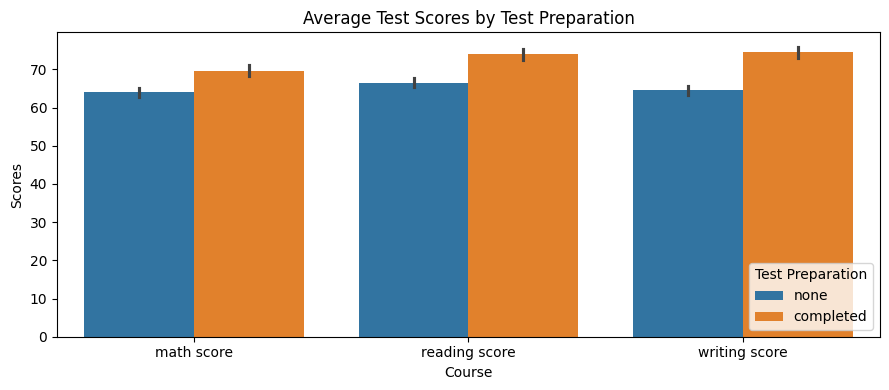

,Course,Test Preparation,Score
0,math score,completed,69.695531
1,math score,none,64.077882
2,reading score,completed,73.893855
3,reading score,none,66.534268
4,writing score,completed,74.418994
5,writing score,none,64.504673


In [ ]:
grade_table= df_reshape.groupby(['courses','test preparation course'])['scores'].mean().reset_index()
grade_table.columns = ['Course','Test Preparation','Score']
plt.figure(figsize =(9,4))
sns.barplot(data=df_reshape,
            x='courses',
            y='scores',
            hue='test preparation course')
plt.title("Average Test Scores by Test Preparation")
plt.xlabel("Course")
plt.ylabel("Scores")
plt.legend(title="Test Preparation", loc="lower right")
plt.tight_layout()
plt.show()


grade_table.style.set_table_styles(
    [
        {'selector': 'th', 'props': [('text-align', 'center'), ('font-size', '13px')]},
        {'selector': 'td', 'props': [('text-align', 'center'), ('font-size', '13px'), ('padding', '10px')]}
    ]
).background_gradient(subset=["Score"], cmap='Blues').set_properties(**{
    'width': '300px'
})

#### <b>The visualization reveals a postive asscoiation between student who completed Test Preparation across the three main subjects. Highest score was writing score with a 74% with test preparation and lowest is math score with no preparation. All test preparation scores lead their none prepare scores Lets test those results using a Bayesian approach</b>

## 3.0 Bayesian Test: Does Test Preparation Improve Scores ?

### 🔍 Bayesian Modeling Approach

We compare the mean test scores for students who completed vs. did not complete a test preparation course using Bayesian inference.

- **Priors:**
  - Group means `mu_completed` and `mu_none` are given normal priors centered at 50 with a standard deviation of 10.
  - A shared standard deviation `sigma` is given a HalfNormal(10) prior.
- **Goal:** Estimate the posterior distribution of both group means, and interpret the probability that students with test preparation perform better.

Output()

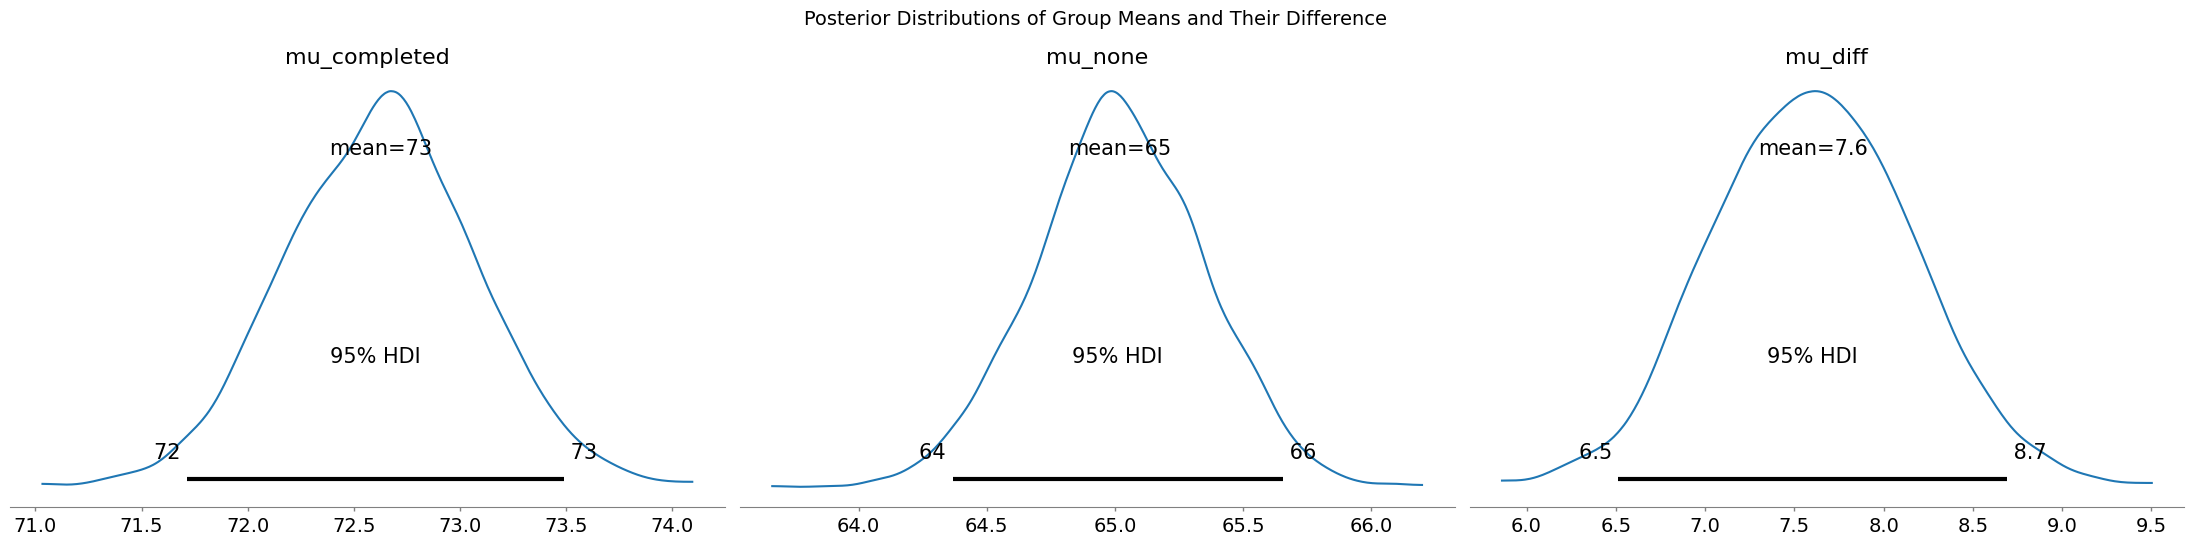

📊 Probability that 'completed' > 'none': 1.000


In [ ]:

completed_scores = df_reshape[df_reshape['test preparation course'] == 'completed']['scores'].values
none_scores = df_reshape[df_reshape['test preparation course'] == 'none']['scores'].values

# Bayesian model with shared sigma and deterministic difference
with pm.Model() as student_model:
    # Priors for group means
    mu_completed = pm.Normal("mu_completed", mu=50, sigma=10)
    mu_none = pm.Normal("mu_none", mu=50, sigma=10)

    # Shared standard deviation
    sigma = pm.HalfNormal("sigma", sigma=10)

    # Likelihoods
    obs_completed = pm.Normal("obs_completed", mu=mu_completed, sigma=sigma, observed=completed_scores)
    obs_none = pm.Normal("obs_none", mu=mu_none, sigma=sigma, observed=none_scores)

    # Deterministic difference of means
    mu_diff = pm.Deterministic("mu_diff", mu_completed - mu_none)

    # Posterior sampling
    trace = pm.sample(1000, return_inferencedata=True, random_seed=42)

# Plot posterior of group means and difference
az.plot_posterior(trace, var_names=["mu_completed", "mu_none", "mu_diff"], hdi_prob=0.95)
plt.suptitle("Posterior Distributions of Group Means and Their Difference", fontsize=14)
plt.tight_layout()
plt.show()

# Extract deterministic difference samples
mu_diff_samples = trace.posterior["mu_diff"].values.flatten()

# Probability that the course improves scores
prob_improvement = (mu_diff_samples > 0).mean()
print(f"📊 Probability that 'completed' > 'none': {prob_improvement:.3f}")









There is a 100% posterior probability  that the completed
test prep group had a higher mean score than the none-prep group.

\** With High certainty, the data supports that completed test preparation leads to a greater score roughly 6.5% to 8.7% increase.** ✔

This Bayesian Hypothesis Testing , was to evaluate the performance of the test preparation scores of students across different subjects. The model was created to compare the average score from student who completed and those who did not. The test was focused on estimating the difference between scores
Completed - none
The posterior distribution of this difference was sampled using PyMC, and summarized with:

    The posterior mean of the score difference is 7.6

    A 95% credible interval (HDI) 6.5 to 8.7

    Posterior Probability that students who completed test prep scored higher:
    P(μ_completed > μ_none) ≈ 1.0 (or 100%)

From a policy perspective, schools may benefit from encouraging or requiring completion of the test prep course, especially for students at risk of underperformance.
